In [516]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns
import common.common_pandas_lib as common
#lugares con mayor cantidad de propiedades son departamento

### Configuraciones librerias

In [517]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (18, 8)

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Funciones auxiliares

In [518]:
font_size = 18
TAM_TITULO = 36
TAM_ETIQUETA = 30

def crear_radares_alineados(df, fil, col, paleta_colores):
    
    # Categorias
    columnas = df.columns
    categorias = list(columnas[1:])
    N = len(categorias)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angulos = [n / float(N) * 2 * pi for n in range(N)]
    angulos += angulos[:1]
    
    # Color
    paleta = plt.cm.get_cmap(paleta_colores, len(df.index))
    
    lista = []
    
    for fila in range(0, len(df.index)):
        color = paleta(fila)
        
        # Initialise the spider plot
        ax = plt.subplot(fil, col, fila + 1, polar=True, )
    
        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
    
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angulos[:-1], categorias, color='grey', size=10)
    
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([1,2,3,4], ["1","2","3","4"], color="grey", size=10)
        plt.ylim(0,4)
        
        # Ind1
        values=df.loc[fila].drop("provincia").values.flatten().tolist()
        values += values[:1]
        ax.plot(angulos, values, color=color, linewidth=1, linestyle='solid')
        ax.fill(angulos, values, color=color, alpha=0.4)
        
        plt.title(df["provincia"][fila], size=16, color=color, y=1.1)
        
        lista.append(ax)
    
    fig, lista = plt.subplots(0)
    #fig.subplots_adjust(left=None, bottom=100, right=None, top=150, wspace=None, hspace=None)


font_size = 18

def crear_mapa(series, caracteristica, vmin, vmax, titulo, titulo_barra, color):
    #Creo mi mapa de mexico
    mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

    #Le pongo los tildes al archivo de estados para que me coincidan con las provincias
    mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

    #Hago un nuevo dataframe con la información del mapa y la antiguedad para cada provincia
    gdf = mexico.set_index("ADMIN_NAME").join(series)
    
    #Grafico el mapa

    #Base donde se va a dibujar
    fig, base = plt.subplots(1, figsize=(10, 6))

    #Si les parece que los ejes están de más, pongan off
    base.axis("on")

    #Pido que me coloreé en base a la caracteristica determinada
    gdf.plot(column=caracteristica, cmap=color, linewidth=0.8, ax=base, edgecolor="0.8")

    #Setteo el título al gráfico
    base.set_title(titulo, fontsize = font_size)
    
    #Agrego la barra que indica la antiguedad
    # l:left, b:bottom, w:width, h:height
    cbax = fig.add_axes([1, 0.15, 0.02, 0.65])   
    cbax.set_title(titulo_barra)
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cbax)
    
def crear_heatmap_porcentaje(df_data, caracteristica, titulo, xlabel, ylabel, color):
    df_data = pd.pivot_table(df_data, index=["provincia"], columns=caracteristica, values="porcentaje")
    df_data = df_data.fillna(0)
    
    hm = sns.heatmap(df_data, linewidths=.5, xticklabels=True, yticklabels=True, cmap = color)
    hm.set_title(titulo, fontsize = TAM_TITULO) 
    hm.set_xlabel(xlabel, fontsize = TAM_ETIQUETA)
    hm.set_ylabel(ylabel, fontsize = TAM_ETIQUETA)
    plt.show()
    
def crear_df_porcentaje_de_provincias(df1, df2, caracteristica):
    """df1: el df de cátedra/
       df2: un df multiindex de la forma {"cantidad": cantidad}, index = [provincia, tipodepropiedad]
       Devuelve un multiindex con el porcentaje para cada tipo de propiedad por provincia"""
    cantidad = df1["provincia"].value_counts()
    index1 = []
    index2 = []
    porcentaje = []
    provincias = set(list(df2.index.get_level_values(0)))
    for provincia in provincias:
        df_provincia = df2.loc[provincia].reset_index()
        for index, row in df_provincia.iterrows():
            index1.append(provincia)
            index2.append(row[caracteristica])
            porcentaje.append((row["cantidad"] * 100) / cantidad[provincia])
    df = pd.DataFrame({"porcentaje": porcentaje}, index = [index1, index2])
    return df

def crear_df_porcentaje_de_caracteristica_provincias(df_reducido, caracteristica):
    df_provincias_caracteristica = df_reducido.groupby("provincia")[caracteristica].value_counts()
    df_provincias_caracteristica = df_provincias_caracteristica.to_frame()
    df_provincias_caracteristica.columns = ["cantidad"]
    df_provincias_caracteristica_porcentaje = crear_df_porcentaje_de_provincias(df_reducido, df_provincias_caracteristica, caracteristica).reset_index()
    df_provincias_caracteristica_porcentaje.columns = ["provincia", caracteristica, "porcentaje"]
    df_provincias_caracteristica_porcentaje = df_provincias_caracteristica_porcentaje.set_index(["provincia", caracteristica])
    return df_provincias_caracteristica_porcentaje

### Carga optimizada del set de datos

In [519]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \
                'tipodepropiedad' : 'category', \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

df = df.dropna(subset=['provincia'])
#df = df.dropna(subset=['antiguedad'])

df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,nan,2.00,1.00,...,"23,533.00",nan,nan,2015-08-23,False,False,False,False,False,"2,273,000.00"
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.00,3.00,2.00,...,"24,514.00",19.31,-99.23,2013-06-28,False,False,False,True,True,"3,600,000.00"
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.00,3.00,2.00,...,"48,551.00",nan,nan,2015-10-17,False,False,False,False,False,"1,200,000.00"
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.00,2.00,1.00,...,"53,666.00",19.30,-99.69,2012-03-09,False,False,False,True,True,"650,000.00"
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.00,2.00,1.00,...,"47,835.00",nan,nan,2016-06-07,False,False,False,False,False,"1,150,000.00"


## Valores de las características

In [520]:
df = df.dropna(subset=['habitaciones'])
df = df.dropna(subset=['banos'])
df = df.dropna(subset=['garages'])

### ¿Qué valores puede tomar habitaciones?

In [521]:
habitacion_valores = df["habitaciones"].unique()
habitacion_valores.sort()
habitacion_valores

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

### ¿Qué valores puede tomar baños?

In [522]:
banos_valores = df["banos"].unique()
banos_valores.sort()
banos_valores

array([1., 2., 3., 4.])

### ¿Qué valores puede tomar garage?

In [523]:
garage_valores = df["garages"].unique()
garage_valores.sort()
garage_valores

array([0., 1., 2., 3.])

### ¿Existen diferencias notables entre las características de las 5 provincias de mayor superficie y las 5 provincias de menor superficie?

In [524]:
mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME
mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)
mexico.Shape_Area.sum()

174.117667456488

In [525]:
def crear_porcentaje_superficie_mexico_df(df_mexico):
    provincia = []
    porcentaje = []
    area_total = df_mexico["Shape_Area"].sum()
    for index, row in df_mexico.iterrows():
        provincia.append(row["ADMIN_NAME"])
        porcentaje.append((row["Shape_Area"] * 100) / area_total)
    dic = {"provincia": provincia, "porcentaje de area": porcentaje}
    return pd.DataFrame(dic)

In [526]:
mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

In [527]:
mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

In [528]:
porcentaje_area_mexico = crear_porcentaje_superficie_mexico_df(mexico)
porcentaje_area_mexico = porcentaje_area_mexico.sort_values("porcentaje de area")
porcentaje_area_mexico

,provincia,porcentaje de area
22,Distrito Federal,0.07
20,Tlaxcala,0.20
23,Morelos,0.25
9,Aguascalientes,0.28
21,Colima,0.28
12,Querétaro,0.60
15,Hidalgo,1.06
19,Edo. de México,1.07
26,Tabasco,1.18
31,Nayarit,1.38


In [529]:
provincias_areas_mayores = porcentaje_area_mexico.nlargest(6, "porcentaje de area")
categorias = ["habitaciones", "banos", "garages"]
provincias_mas_grandes = list(provincias_areas_mayores["provincia"])
provincias_mas_grandes_df = df[df["provincia"].isin(list(provincias_areas_mayores["provincia"]))]
provincias_mas_grandes_df = provincias_mas_grandes_df.groupby("provincia")[categorias].mean()
provincias_mas_grandes_df = provincias_mas_grandes_df.reset_index()
provincias_mas_grandes_df = provincias_mas_grandes_df.merge(provincias_areas_mayores, how = "inner")
provincias_mas_grandes_df = provincias_mas_grandes_df.sort_values("porcentaje de area", ascending = False)
provincias_mas_grandes_df

,provincia,habitaciones,banos,garages,porcentaje de area
0,Chihuahua,3.02,2.10,1.62,13.15
4,Sonora,2.88,1.92,1.49,9.67
1,Coahuila,2.98,2.11,1.62,7.89
2,Durango,3.02,1.93,1.54,6.18
3,Oaxaca,2.86,1.83,1.33,4.50
5,Tamaulipas,2.80,1.93,1.52,4.05


In [530]:
provincias_mas_grandes_df = provincias_mas_grandes_df.drop("porcentaje de area", axis=1)
provincias_mas_grandes_df = provincias_mas_grandes_df.set_index("provincia")

In [531]:
provincias_areas_menores = porcentaje_area_mexico.nsmallest(6, "porcentaje de area")
categorias = ["habitaciones", "banos", "garages"]
provincias_mas_chicas = list(provincias_areas_menores["provincia"])
provincias_mas_chicas_df = df[df["provincia"].isin(list(provincias_areas_menores["provincia"]))]
provincias_mas_chicas_df = provincias_mas_chicas_df.groupby("provincia")[categorias].mean()
provincias_mas_chicas_df = provincias_mas_chicas_df.reset_index()
provincias_mas_chicas_df = provincias_mas_chicas_df.merge(provincias_areas_menores, how = "inner")
provincias_mas_chicas_df = provincias_mas_chicas_df.sort_values("porcentaje de area")
provincias_mas_chicas_df

,provincia,habitaciones,banos,garages,porcentaje de area
2,Distrito Federal,2.63,1.92,1.52,0.07
5,Tlaxcala,2.80,1.52,1.46,0.20
3,Morelos,2.90,2.29,1.80,0.25
0,Aguascalientes,3.04,2.09,1.65,0.28
1,Colima,2.70,2.01,1.42,0.28
4,Querétaro,2.93,2.36,1.91,0.60


In [532]:
provincias_mas_chicas_df = provincias_mas_chicas_df.drop("porcentaje de area", axis=1)
provincias_mas_chicas_df = provincias_mas_chicas_df.set_index("provincia")
provincias_mas_chicas_df

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.63,1.92,1.52
Tlaxcala,2.80,1.52,1.46
Morelos,2.90,2.29,1.80
Aguascalientes,3.04,2.09,1.65
Colima,2.70,2.01,1.42
Querétaro,2.93,2.36,1.91


### Provincias de mayor superficie de Mexico

<Figure size 1800x800 with 0 Axes>

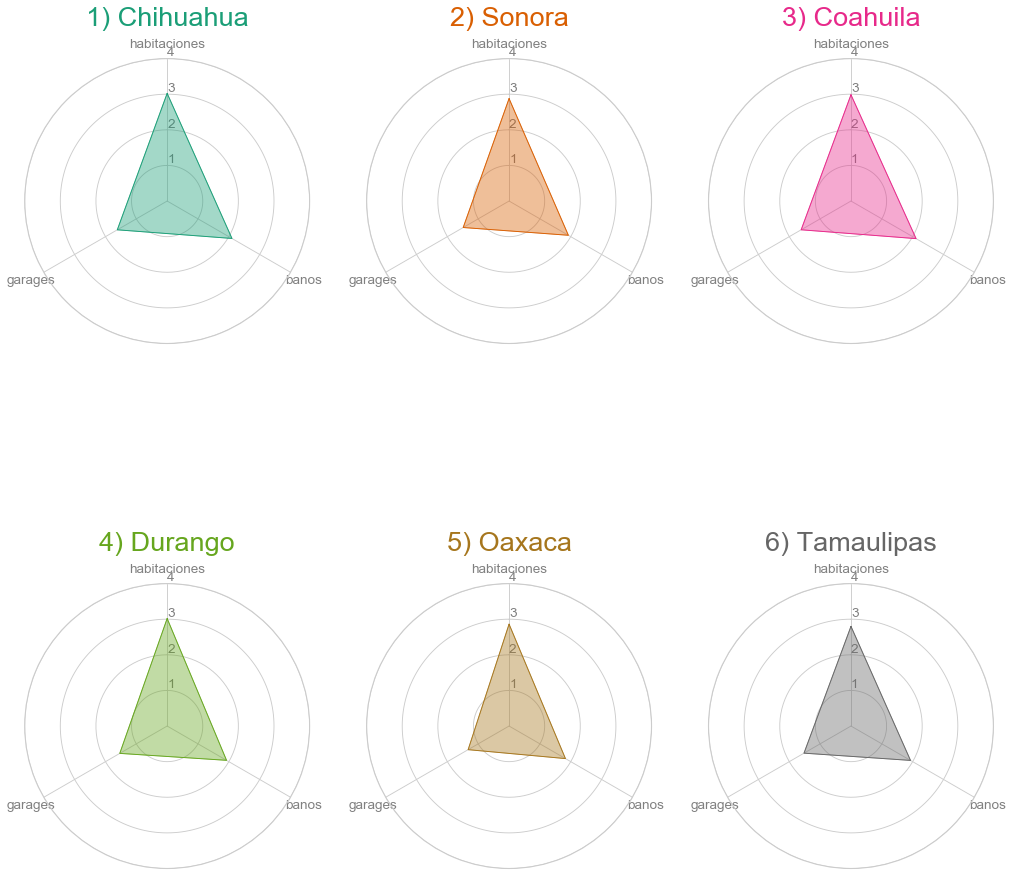

<Figure size 1800x800 with 0 Axes>

In [533]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
common.crear_radares_alineados(provincias_mas_grandes_df.reset_index(), 2, 3, "Dark2")

### Provincias de menor superficie de Mexico

<Figure size 1800x800 with 0 Axes>

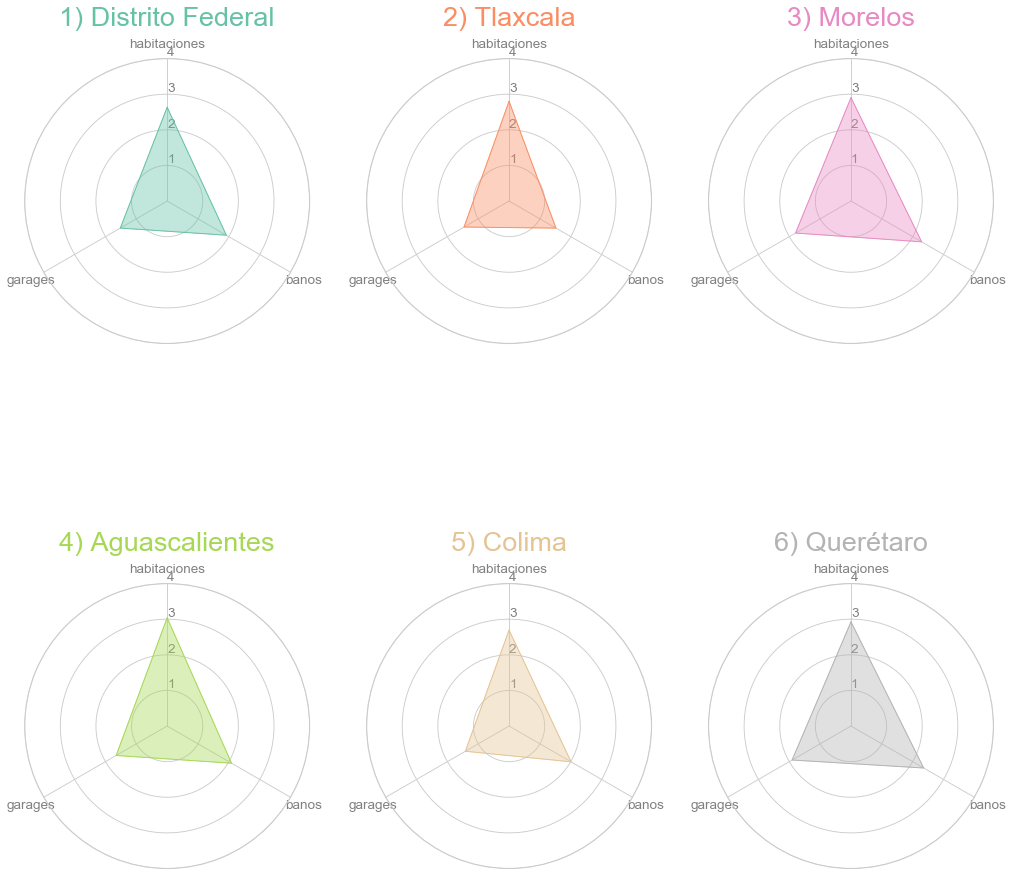

<Figure size 1800x800 with 0 Axes>

In [534]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
common.crear_radares_alineados(provincias_mas_chicas_df.reset_index(), 2, 3, "Set2")

### ¿Todas las provincias poseen una misma distribución de cantidades habitaciones? ¿Son 3 baños los que más abundan en relación a los otros?

In [535]:
df

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,nan,2.00,1.00,...,"23,533.00",nan,nan,2015-08-23,False,False,False,False,False,"2,273,000.00"
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.00,3.00,2.00,...,"24,514.00",19.31,-99.23,2013-06-28,False,False,False,True,True,"3,600,000.00"
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.00,3.00,2.00,...,"48,551.00",nan,nan,2015-10-17,False,False,False,False,False,"1,200,000.00"
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.00,2.00,1.00,...,"53,666.00",19.30,-99.69,2012-03-09,False,False,False,True,True,"650,000.00"
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.00,2.00,1.00,...,"47,835.00",nan,nan,2016-06-07,False,False,False,False,False,"1,150,000.00"
5,126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Apartamento,Condominio Tlalpan 2B,Coyoacán,Distrito Federal,5.00,2.00,1.00,...,"23,650.00",19.30,-99.15,2014-03-18,False,False,False,False,True,"1,100,000.00"
6,139233,de oportunidad casa en san lorenzo,"ubicada en esquina, pertenece san lorenzo agen...",Casa,NaN,Oaxaca de Juárez,Oaxaca,nan,3.00,1.00,...,"73,510.00",17.14,-96.80,2016-02-23,False,False,False,False,False,"1,150,000.00"
7,5013,casa emilia en venta en selvamar playa del carmen,casa emilia en venta playa del carmenfracciona...,Casa,condominio el trebol,Playa del Carmen,Quintana Roo,2.00,4.00,2.00,...,"130,510.00",20.67,-87.04,2016-10-20,False,False,False,False,False,"4,200,000.00"
8,44962,pre- venta preciosos depas 2 recamaras con sub...,<p>pre-venta de preciosos departamento ecologi...,Apartamento,BUENAVISTA DEPTOS CON SUBSIDIO,Villa de Alvarez,Colima,1.00,2.00,1.00,...,"9,010.00",nan,nan,2014-01-06,False,False,False,True,True,"310,000.00"
10,51180,mi 2° credito,<p>mi 2&deg; credito<br />para todos aquellos ...,Casa,MI 2° CREDITO,San Luis Potosí,San luis Potosí,0.00,3.00,1.00,...,"87,542.00",22.20,-101.02,2013-01-03,False,False,False,True,True,"488,000.00"


### Promedio de habitaciones por provincia

In [536]:
provincia_habitaciones_promedio = df.groupby("provincia")["habitaciones"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x184d8faca20>)

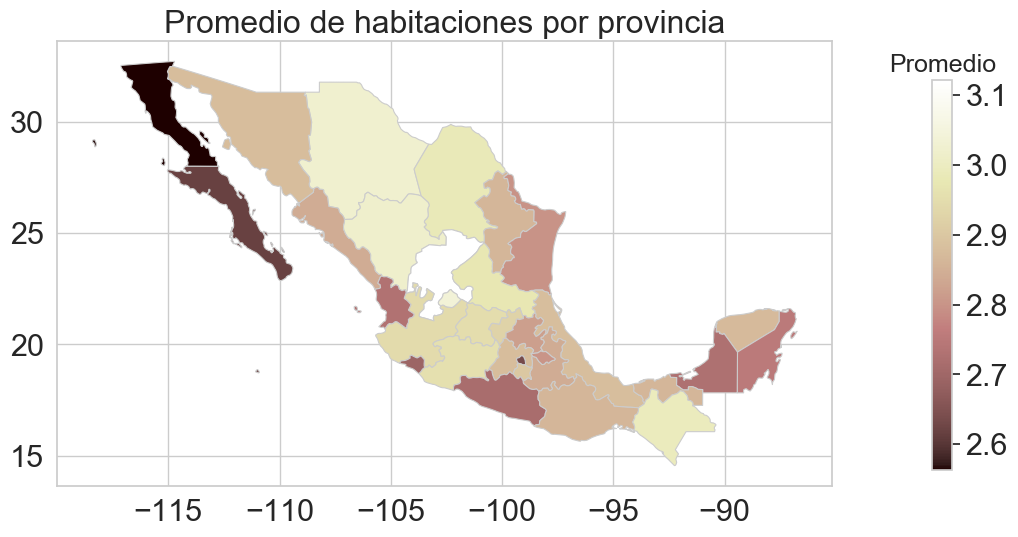

<Figure size 1250x1250 with 0 Axes>

In [537]:
common.crear_mapa(provincia_habitaciones_promedio, "habitaciones", provincia_habitaciones_promedio.min(), provincia_habitaciones_promedio.max(), "Promedio de habitaciones por provincia", "Promedio", "pink")

### Promedio de baños por provincia

In [538]:
provincia_banos_promedio = df.groupby("provincia")["banos"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x184ce7077b8>)

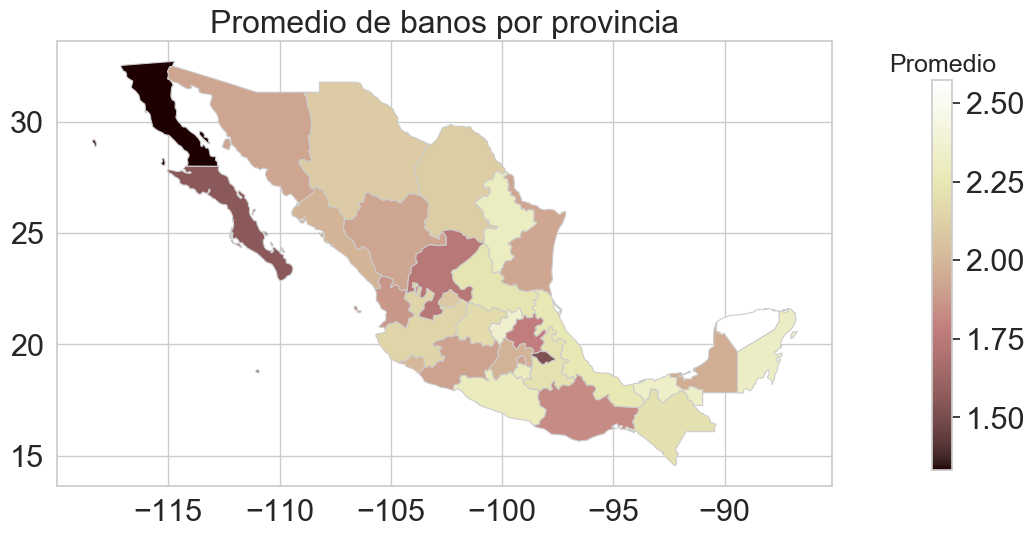

<Figure size 1250x1250 with 0 Axes>

In [539]:
common.crear_mapa(provincia_banos_promedio, "banos", provincia_banos_promedio.min(),
           provincia_banos_promedio.max(), "Promedio de banos por provincia", "Promedio", "pink")

### Promedio de garages por provincia

In [540]:
provincia_garage_promedio = df.groupby("provincia")["garages"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1849c06bc50>)

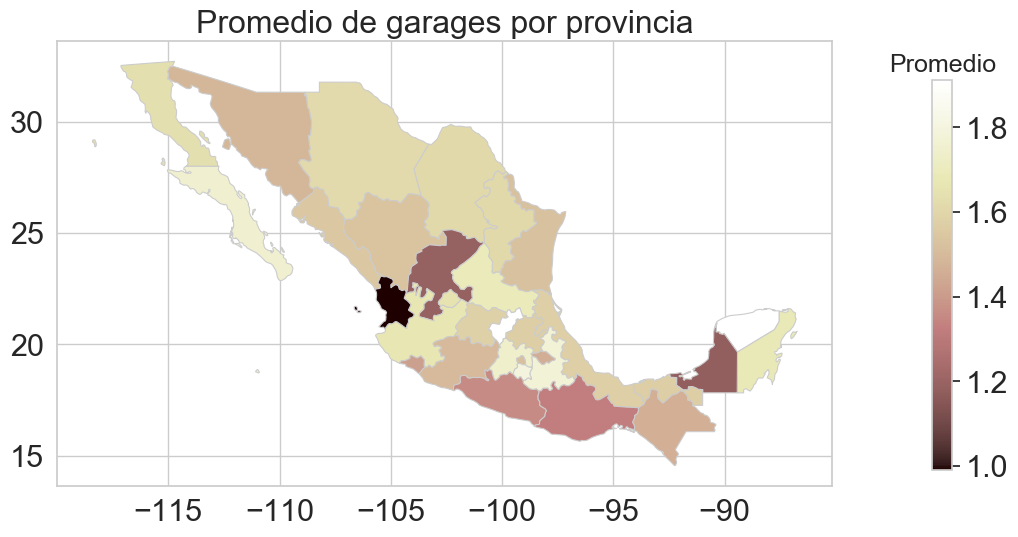

<Figure size 1250x1250 with 0 Axes>

In [541]:
common.crear_mapa(provincia_garage_promedio, "garages", provincia_garage_promedio.min(),
           provincia_garage_promedio.max(), "Promedio de garages por provincia", "Promedio", "pink")

### ¿Existe un patrón en las características de las provincias con más cantidad de propiedades?

In [542]:
provincias_cantidad_propiedades = df["provincia"].value_counts()
provincias_mas_propiedades = provincias_cantidad_propiedades.nlargest(6)
provincias_mas_propiedades = list(provincias_mas_propiedades.index)

categorias = ["habitaciones", "banos", "garages"]
provincias_mas_propiedades = df[df["provincia"].isin(list(provincias_mas_propiedades))]
provincias_mas_propiedades = provincias_mas_propiedades.groupby("provincia")[categorias].mean()
provincias_mas_propiedades

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.63,1.92,1.52
Edo. de México,2.88,1.98,1.74
Jalisco,2.95,2.15,1.67
Nuevo León,2.86,2.30,1.61
Puebla,2.84,2.21,1.77
Querétaro,2.93,2.36,1.91


<Figure size 1800x800 with 0 Axes>

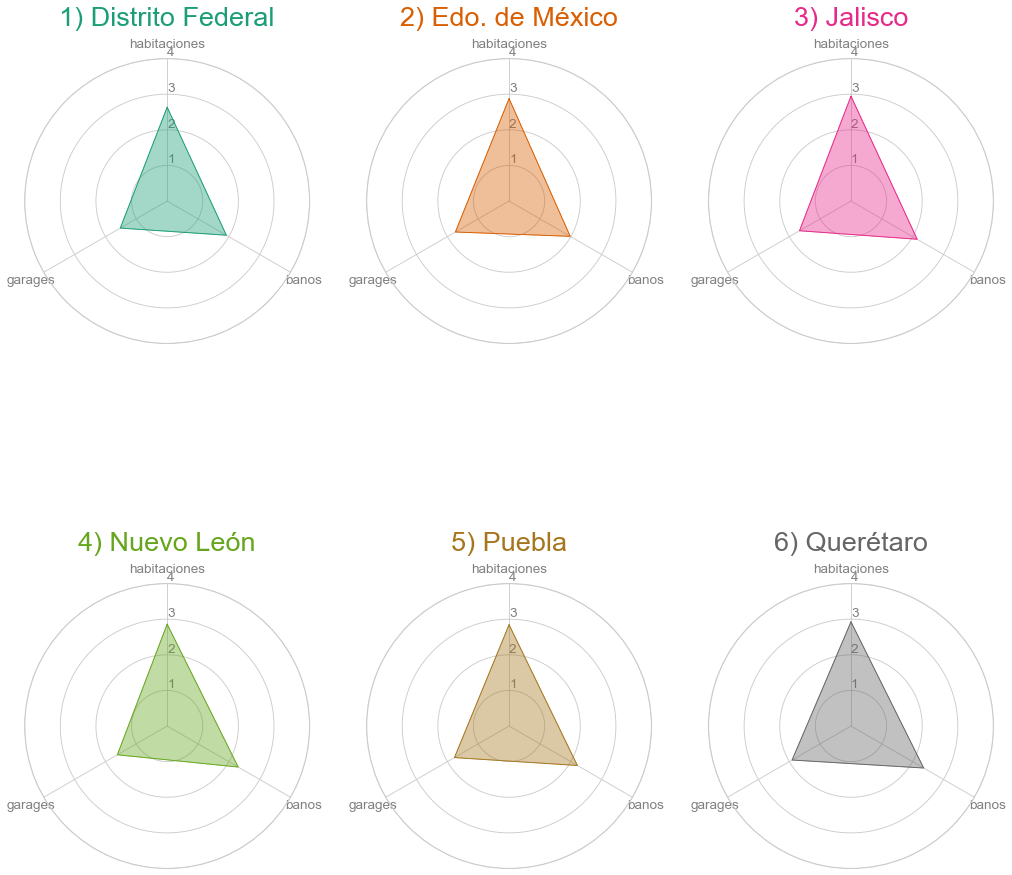

<Figure size 1800x800 with 0 Axes>

In [543]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
common.crear_radares_alineados(provincias_mas_propiedades.reset_index(), 2, 3, "Dark2")

### Distribución de habitaciones:

In [544]:
#Elimino las provs con menos de 3000
provincias_validas = df["provincia"].value_counts() > 3000
provincias_validas = provincias_validas[provincias_validas == True]
provincias_validas = list(provincias_validas.index)
df_reducido = df[df["provincia"].isin(provincias_validas)]

In [545]:
df_provincias_habitaciones_porcentaje = crear_df_porcentaje_de_caracteristica_provincias(df_reducido, "habitaciones")

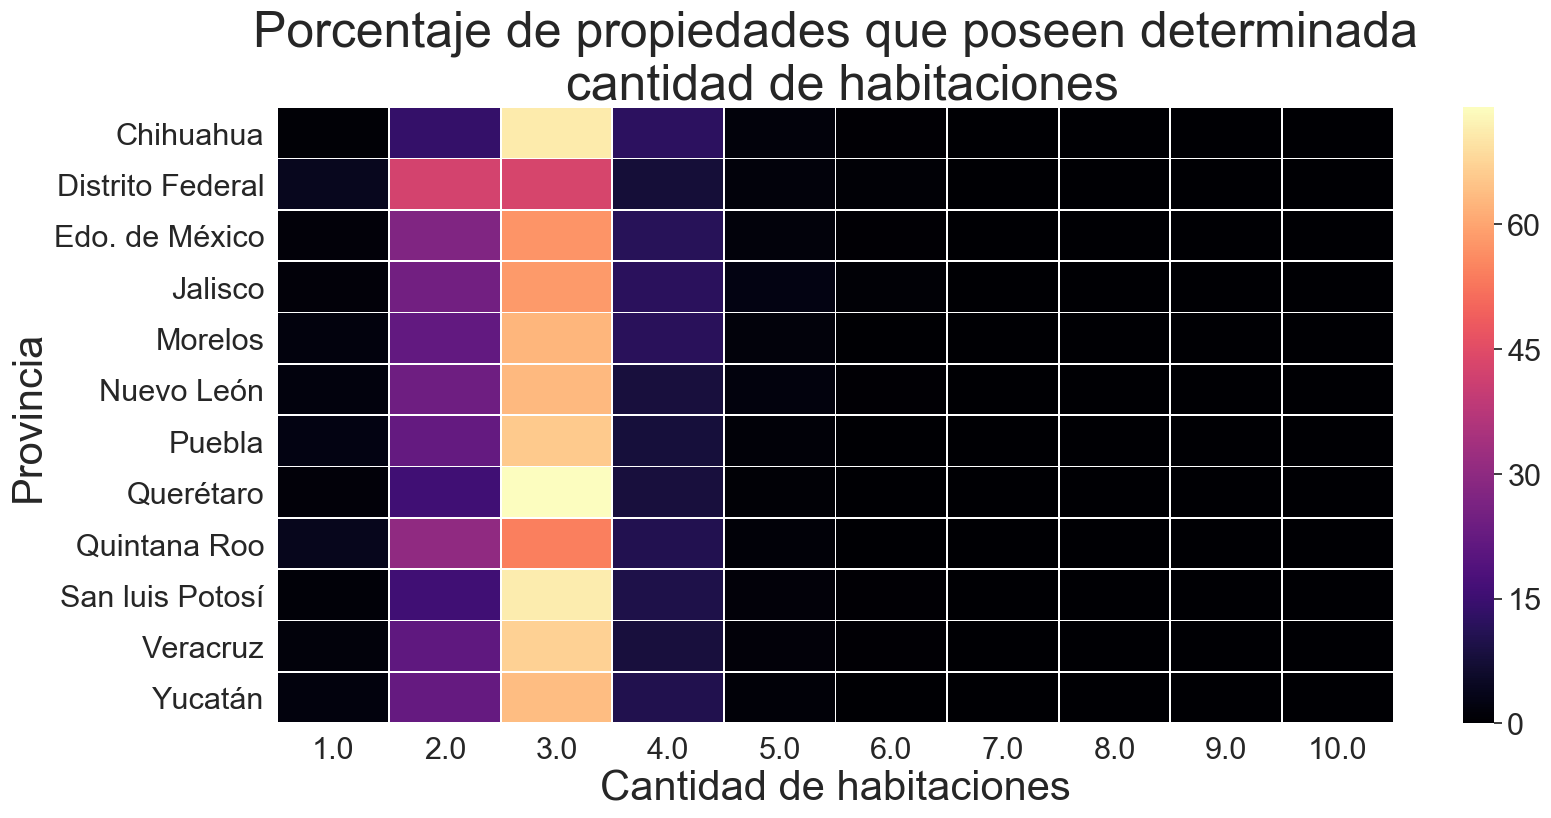

In [546]:
crear_heatmap_porcentaje(df_provincias_habitaciones_porcentaje, "habitaciones", "Porcentaje de propiedades que poseen determinada\n cantidad de habitaciones", "Cantidad de habitaciones", "Provincia", "magma")

### Distribución de baños:

In [547]:
df_provincias_banos_porcentaje = crear_df_porcentaje_de_caracteristica_provincias(df_reducido, "banos")

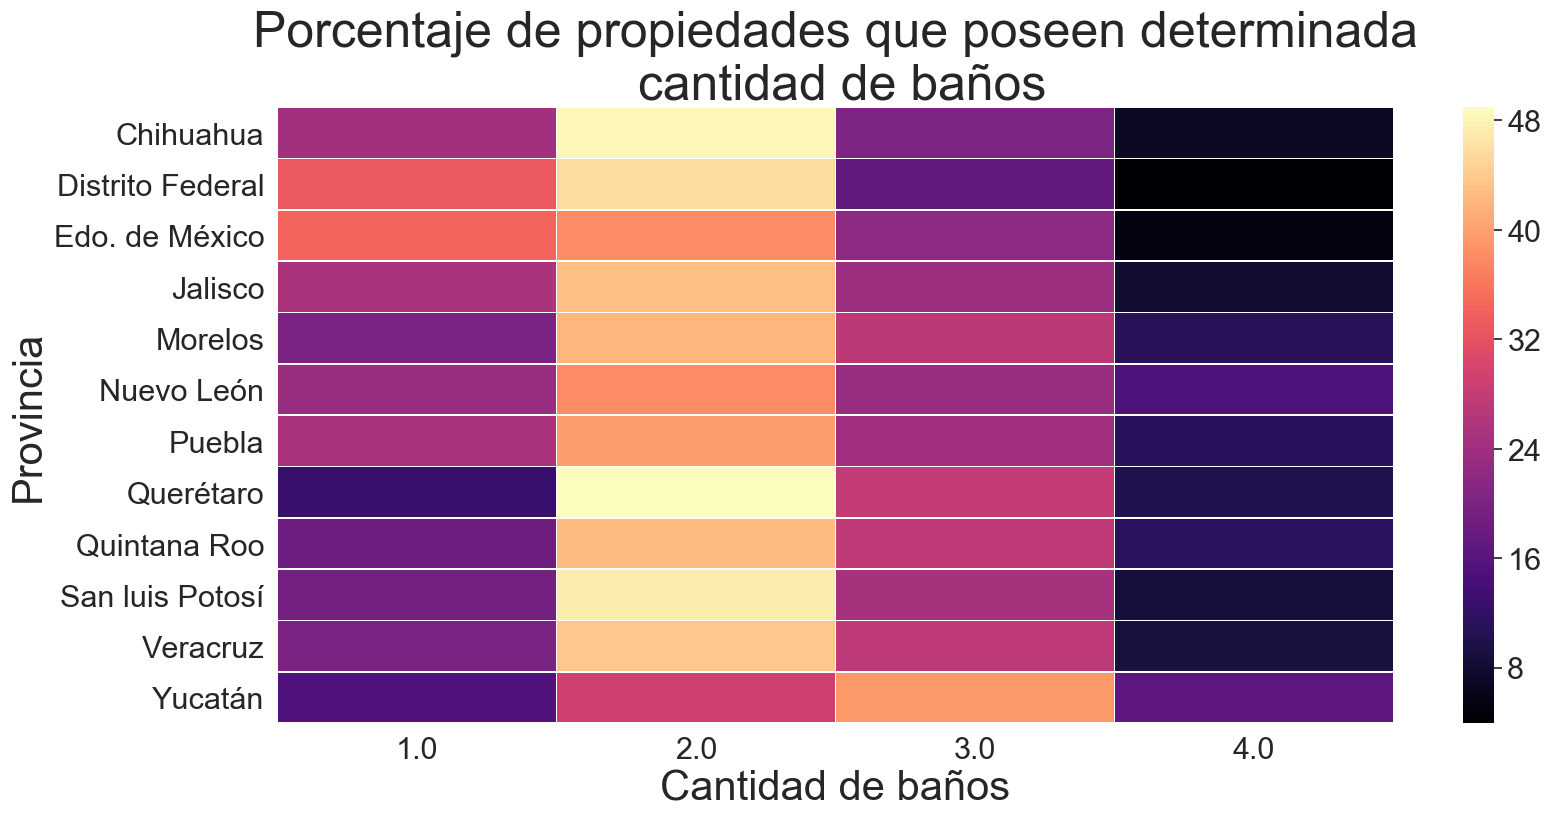

In [548]:
crear_heatmap_porcentaje(df_provincias_banos_porcentaje, "banos","Porcentaje de propiedades que poseen determinada\n cantidad de baños", "Cantidad de baños", "Provincia", "magma")

### Distribución de garages

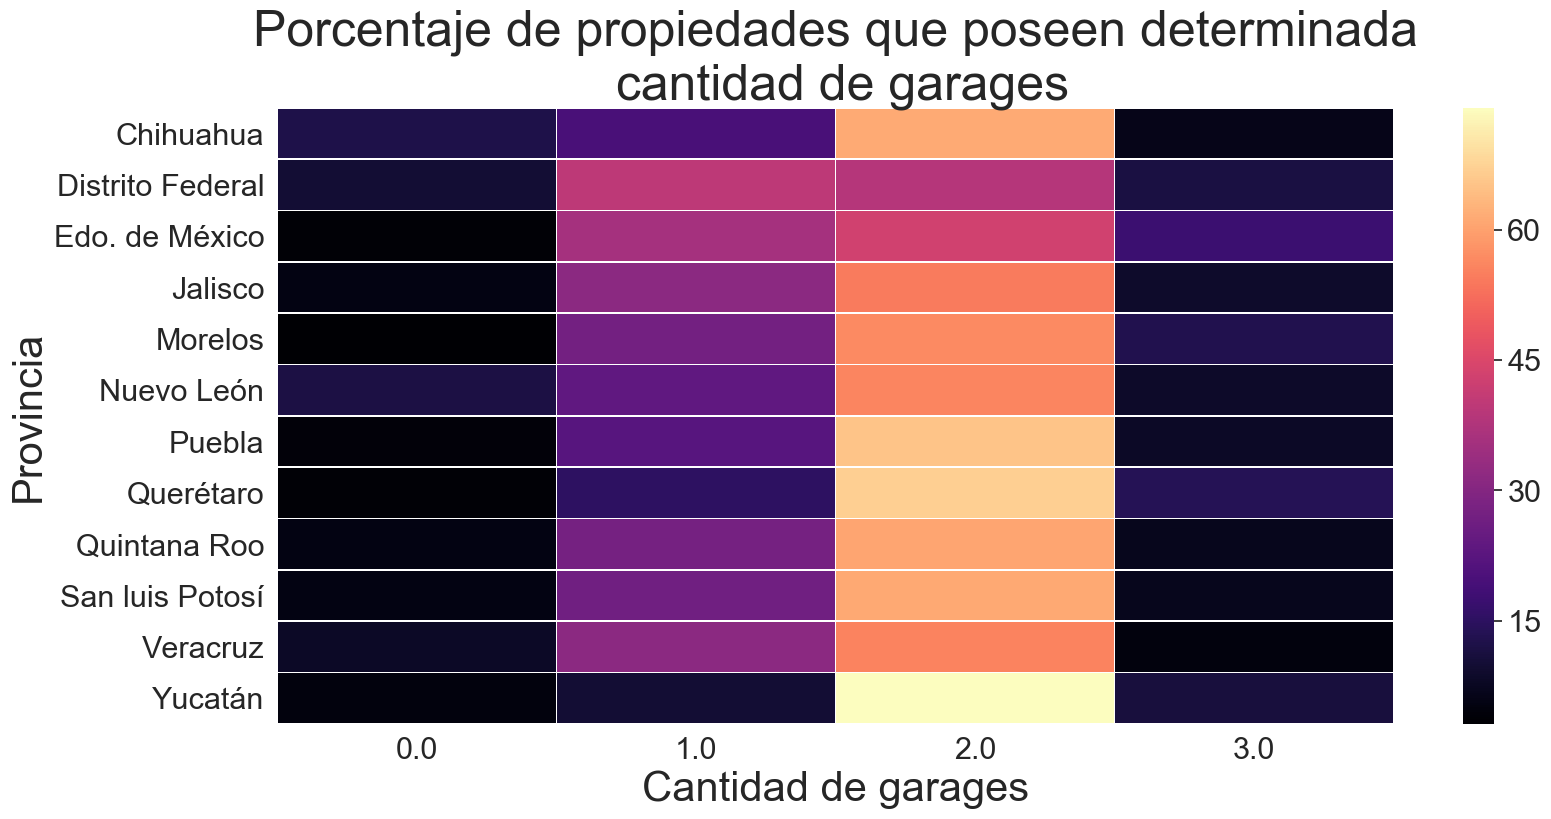

In [549]:
df_provincias_banos_porcentaje = crear_df_porcentaje_de_caracteristica_provincias(df_reducido, "garages")
crear_heatmap_porcentaje(df_provincias_banos_porcentaje, "garages","Porcentaje de propiedades que poseen determinada\n cantidad de garages", "Cantidad de garages", "Provincia", "magma")